In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

conn = engine.connect()

# Exploratory Climate Analysis

In [10]:
# Early exploration Measurement
measurement_pd = pd.read_sql("SELECT * FROM Measurement", conn)
#measurement_pd.dtypes
# measurement_pd.head()
sorted_measurement = measurement_pd.sort_values(['date'], ascending=False)
sorted_measurement.head()

,id,station,date,prcp,tobs
19549,19550,USC00516128,2017-08-23,0.45,76.0
12186,12187,USC00519523,2017-08-23,0.08,82.0
2723,2724,USC00519397,2017-08-23,0.00,81.0
7634,7635,USC00514830,2017-08-23,0.00,82.0
12185,12186,USC00519523,2017-08-22,0.00,82.0


In [11]:
# Early exploration Station
station_pd = pd.read_sql("SELECT * FROM Station", conn)
#station_pd.dtypes
station_pd.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores

one_year_prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > '2016-08-22').order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

prcp_df = pd.DataFrame(data=one_year_prcp, columns=['date', 'precipitation'])
prcp_df.set_index('date', inplace=True)

# Sort the dataframe by date
prcp_df_sorted = prcp_df.sort_values('date', ascending=True)

# Checking if it looks correct so far
prcp_df_sorted.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


In [13]:
# Clean up NA's so they don't cloud the visual
prcp_df_final = prcp_df_sorted.dropna()
prcp_df_final.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79


In [14]:
# use shape for counting rows and columns
prcp_df_final.shape

(2021, 1)

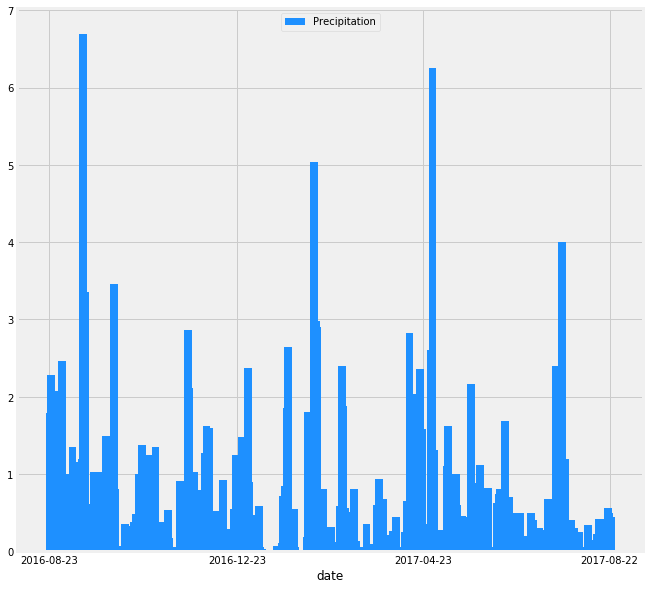

In [129]:
# y_axis = prcp_df_sorted['precipitation']

# Use Pandas Plotting with Matplotlib to plot the data
# prcp_df_sorted.plot.bar()

# HAS TO BE BOEFRE!!!!
width = 10
height = 10
plt.figure(figsize=(width, height))

plt.bar(prcp_df_final.index, prcp_df_final['precipitation'], color="dodgerblue", width=5)
plt.legend(["Precipitation"], loc="upper center")


plt.grid(True)
# plt.grid(axis='both',which='both', linewidth=1)

# add 2 other dates
plt.xticks(["2016-08-23","2016-12-23", "2017-04-23", "2017-08-22"])
plt.xlabel("date")



# plt.tight_layout()
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data

prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# Design a query to show how many stations are available in this dataset?
# USING PANDAS + SQL
count_station = pd.read_sql("SELECT COUNT(DISTINCT station) FROM Measurement", conn)
count_station


,COUNT(DISTINCT station)
0,9


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

station_rows = pd.read_sql("SELECT station, COUNT(*) FROM Measurement GROUP BY station ORDER BY COUNT(*) DESC", conn)
station_rows

,station,COUNT(*)
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
sel = [Measurement.station,
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)]

session.query(*sel).filter(Measurement.station=='USC00519281').all()


[('USC00519281', 54.0, 85.0, 71.66378066378067)]

<Figure size 720x720 with 0 Axes>

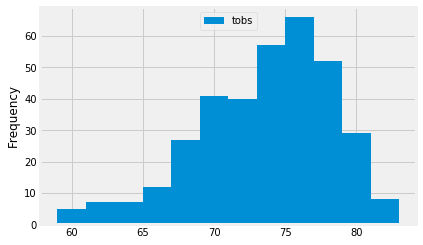

In [131]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# session.query(Measurement.tobs).filter(Measurement.station=='USC00519281').all()


temp_station = pd.read_sql("SELECT tobs AS Frequency FROM Measurement \
WHERE station='USC00519281' AND date > '2016-08-23' ORDER BY tobs", conn)
# temp_station

temp_station.plot.hist(bins=12)
plt.legend(["tobs"], loc="upper center")

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2017-02-28', '2017-03-05'))

# make the result an object
results = calc_temps('2017-02-28', '2017-03-05')

[(64.0, 72.02777777777777, 78.0)]


In [115]:
# get rid of the tuple so I can access the results by index

result_list = list(np.ravel(results))

min_value = result_list[0]
max_value = result_list[2]
Avg_value = result_list[1]
# xlabel = "1"
# x = np.arange(len(xlabel))


error = [result_list[1]-result_list[0], result_list[2]-result_list[1]]

error_array = np.asarray(error)
# (error_array[1] - error_array[0])/2
error_array

array([8.02777778, 5.97222222])

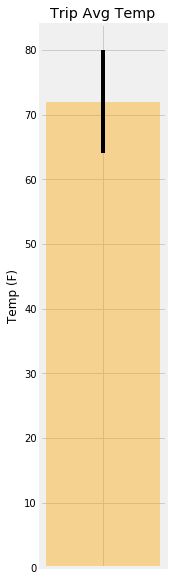

In [132]:
# Plot the results from your previous query as a bar chart. 

# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# plt.bar("x axis",Avg_value, color="orange", alpha = 0.4, width = 0.35, align='center')
width = 2
height = 10
plt.figure(figsize=(width, height))

plt.bar(" ",Avg_value, color="orange", alpha = 0.4, width="5%", yerr=[[error_array]])

# Use "Trip Avg Temp" as your Title
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.show()


In [262]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# TRIP DATES I CHOOSE: AUG 1 - AUG 7 2017

date_range = session.query(Measurement.station, Measurement.prcp, Measurement.date,).filter(Measurement.date>'2016-08-01')\
    .filter(Measurement.date< '2016-08-08').all()
# date_range

date_range_pd = pd.DataFrame(data=date_range, columns=['station', 'prcp', 'date'])

date_range_pd_final = date_range_pd.dropna()


In [267]:
station_pd.set_index('station')
date_range_pd_final.set_index('station')
new_pd = station_pd.join(date_range_pd_final.set_index('station'), on='station', rsuffix='_other')
# new_pd 

In [268]:
vacay_rain = new_pd.groupby(['station']).agg(
{
    'name':'sum',
    'latitude':'mean',
    'longitude':'mean',
    'elevation':'mean',
    'prcp':'sum'
})
vacay_rain

,name,latitude,longitude,elevation,prcp
station,,,,,
USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,0.00
USC00513117,"KANEOHE 838.1, HI USKANEOHE 838.1, HI USKANEOH...",21.42340,-157.80150,14.6,1.24
USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI USKUALOA R...",21.52130,-157.83740,7.0,1.03
USC00516128,"MANOA LYON ARBO 785.2, HI USMANOA LYON ARBO 78...",21.33310,-157.80250,152.4,2.44
USC00517948,"PEARL CITY, HI USPEARL CITY, HI USPEARL CITY, ...",21.39340,-157.97510,11.9,0.18
USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6,0.00
USC00519281,"WAIHEE 837.5, HI USWAIHEE 837.5, HI USWAIHEE 8...",21.45167,-157.84889,32.9,2.49
USC00519397,"WAIKIKI 717.2, HI USWAIKIKI 717.2, HI USWAIKIK...",21.27160,-157.81680,3.0,0.49
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI USWAIMANALO EX...",21.33556,-157.71139,19.5,0.76


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
